In [ ]:
# Install required packages.
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git


     |████████████████████████████████| 11.9MB 1.5MB/s 
     |████████████████████████████████| 24.3MB 137kB/s 
     |████████████████████████████████| 235kB 7.7MB/s 
     |████████████████████████████████| 2.2MB 13.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [ ]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Amazon
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import train_test_split_edges

In [ ]:
dataset = Amazon(root='data/Amazon', name='Photo', transform=NormalizeFeatures())
data = dataset[0]

# Don't need labels or node masks
data.train_mask = data.val_mask = data.test_mask = data.y = None

# Train test split edges
data = train_test_split_edges(data, val_ratio=0.15,test_ratio=0.8)

out_channels = 16
num_features = dataset.num_features
epochs = 1000




Processing...
Done!


In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x



In [ ]:
def train(model, optimizer, data, variational):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    if variational:
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

In [ ]:

def run_training():
  auc_values = []
  ap_values = []
  for epoch in range(1, epochs+1):
      loss = train(model, optimizer, data, variational=False)
      auc, ap = test(model, data)
      auc_values.append(auc)
      ap_values.append(ap)
     # print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
  
  return auc, ap, auc_values, ap_values

final_auc = []
final_ap =[]
for i in range(10):
  # Don't need labels or node masks
  data.train_mask = data.val_mask = data.test_mask = data.y = None

  # Train test split edges
  data = dataset[0]
  data = train_test_split_edges(data, val_ratio=0.15,test_ratio=0.8)

  out_channels = 16
  num_features = dataset.num_features
  epochs = 1000

  model = GAE(GCNEncoder(num_features, out_channels))

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  auc, ap, auc_values, ap_values = run_training()
  final_auc.append(auc)
  final_ap.append(ap)

auc_var = np.var(final_auc)
auc_mean = np.mean(final_auc)
ap_var = np.var(final_ap)
ap_mean = np.mean(final_ap)
print(f'Average AUC: {auc_mean:.4f}, AUC Variance: {auc_var:.4f}')
print(f'Average AP: {ap_mean:.4f}, AP Variance: {ap_var:.4f}')

Average AUC: 0.8816, AUC Variance: 0.0000
Average AP: 0.8854, AP Variance: 0.0000


In [ ]:
print(final_auc)
print(final_ap)

[0.8784733394697319, 0.8865459331069255, 0.8757896346142245, 0.8884073481416817, 0.8811365639620721, 0.880623727851483, 0.882444255491382, 0.8784454875025127, 0.885036124269135, 0.8793885995544062]
[0.8812319914835883, 0.8924544448216247, 0.880602861943956, 0.8879218947630381, 0.8836431686338488, 0.8845160696020339, 0.8879310322570158, 0.8819804204090373, 0.8896066865618264, 0.8843051187254272]


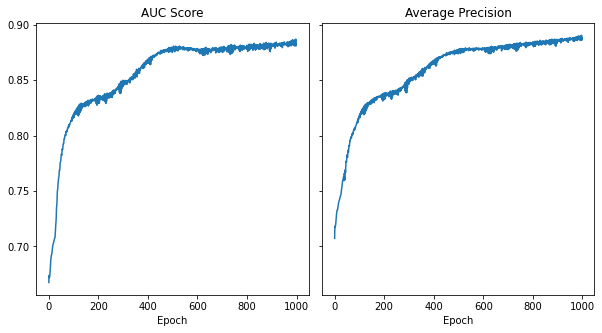

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 5), sharex='all', sharey='all',
                        gridspec_kw={'hspace': 0, 'wspace': 0.05})
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_title('AUC Score')
axs[1].set_title('Average Precision')

axs[0].plot(auc_values, label = "AUC score")
axs[1].plot(ap_values, label = "Average Precision")

plt.show()

In [ ]:
model = VGAE(VariationalGCNEncoder(num_features, out_channels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

auc_values = []
ap_values = []
for epoch in range(1, epochs+1):
    loss = train(model, optimizer, data, variational=True)
    auc, ap = test(model, data)
    auc_values.append(auc)
    ap_values.append(ap)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.6636, AP: 0.7063
Epoch: 002, AUC: 0.6643, AP: 0.7098
Epoch: 003, AUC: 0.6644, AP: 0.7106
Epoch: 004, AUC: 0.6640, AP: 0.7104
Epoch: 005, AUC: 0.6636, AP: 0.7101
Epoch: 006, AUC: 0.6630, AP: 0.7096
Epoch: 007, AUC: 0.6624, AP: 0.7090
Epoch: 008, AUC: 0.6619, AP: 0.7085
Epoch: 009, AUC: 0.6613, AP: 0.7080
Epoch: 010, AUC: 0.6606, AP: 0.7072
Epoch: 011, AUC: 0.6600, AP: 0.7066
Epoch: 012, AUC: 0.6595, AP: 0.7061
Epoch: 013, AUC: 0.6592, AP: 0.7058
Epoch: 014, AUC: 0.6594, AP: 0.7061
Epoch: 015, AUC: 0.6597, AP: 0.7064
Epoch: 016, AUC: 0.6598, AP: 0.7065
Epoch: 017, AUC: 0.6597, AP: 0.7063
Epoch: 018, AUC: 0.6595, AP: 0.7061
Epoch: 019, AUC: 0.6590, AP: 0.7055
Epoch: 020, AUC: 0.6585, AP: 0.7049
Epoch: 021, AUC: 0.6581, AP: 0.7045
Epoch: 022, AUC: 0.6579, AP: 0.7043
Epoch: 023, AUC: 0.6577, AP: 0.7041
Epoch: 024, AUC: 0.6576, AP: 0.7040
Epoch: 025, AUC: 0.6574, AP: 0.7038
Epoch: 026, AUC: 0.6570, AP: 0.7034
Epoch: 027, AUC: 0.6565, AP: 0.7029
Epoch: 028, AUC: 0.6562, AP:

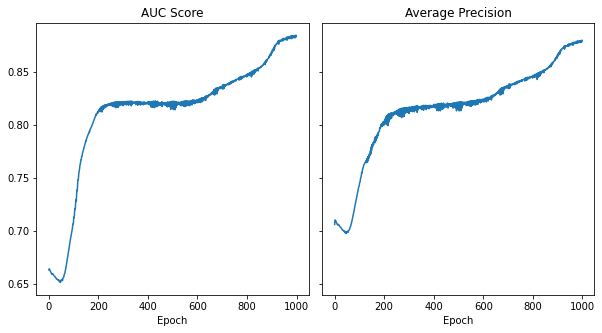

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 5), sharex='all', sharey='all',
                        gridspec_kw={'hspace': 0, 'wspace': 0.05})
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_title('AUC Score')
axs[1].set_title('Average Precision')

axs[0].plot(auc_values, label = "AUC score")
axs[1].plot(ap_values, label = "Average Precision")

plt.show()


In [ ]:
model = GAE(GCN(num_features, out_channels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

auc_values = []
ap_values = []
for epoch in range(1, epochs+1):
    loss = train(model, optimizer, data, variational=False)
    auc, ap = test(model, data)
    auc_values.append(auc)
    ap_values.append(ap)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.6706, AP: 0.7126
Epoch: 002, AUC: 0.6682, AP: 0.7140
Epoch: 003, AUC: 0.6679, AP: 0.7140
Epoch: 004, AUC: 0.6683, AP: 0.7143
Epoch: 005, AUC: 0.6726, AP: 0.7178
Epoch: 006, AUC: 0.6788, AP: 0.7228
Epoch: 007, AUC: 0.6813, AP: 0.7247
Epoch: 008, AUC: 0.6814, AP: 0.7246
Epoch: 009, AUC: 0.6804, AP: 0.7238
Epoch: 010, AUC: 0.6815, AP: 0.7246
Epoch: 011, AUC: 0.6851, AP: 0.7277
Epoch: 012, AUC: 0.6881, AP: 0.7301
Epoch: 013, AUC: 0.6895, AP: 0.7312
Epoch: 014, AUC: 0.6886, AP: 0.7305
Epoch: 015, AUC: 0.6904, AP: 0.7318
Epoch: 016, AUC: 0.6933, AP: 0.7341
Epoch: 017, AUC: 0.6924, AP: 0.7329
Epoch: 018, AUC: 0.6913, AP: 0.7317
Epoch: 019, AUC: 0.6944, AP: 0.7343
Epoch: 020, AUC: 0.6968, AP: 0.7366
Epoch: 021, AUC: 0.6974, AP: 0.7364
Epoch: 022, AUC: 0.6958, AP: 0.7347
Epoch: 023, AUC: 0.6992, AP: 0.7373
Epoch: 024, AUC: 0.7020, AP: 0.7399
Epoch: 025, AUC: 0.7027, AP: 0.7405
Epoch: 026, AUC: 0.7027, AP: 0.7402
Epoch: 027, AUC: 0.7036, AP: 0.7415
Epoch: 028, AUC: 0.7047, AP:

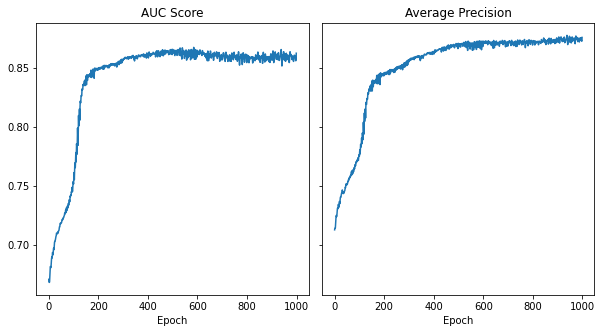

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 5), sharex='all', sharey='all',
                        gridspec_kw={'hspace': 0, 'wspace': 0.05})
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_title('AUC Score')
axs[1].set_title('Average Precision')

axs[0].plot(auc_values, label = "AUC score")
axs[1].plot(ap_values, label = "Average Precision")

plt.show()


In [ ]:
model.eval()
z = model.encode(data.x, data.train_pos_edge_index)

res = model.decod(z)

print(res.shape)

In [ ]:
new_data = dataset[0]
# Don't need labels or node masks
new_data.train_mask = new_data.val_mask = new_data.test_mask = new_data.y = None
# Train test split edges
new_data = train_test_split_edges(new_data, val_ratio=0.20,test_ratio=0.8)

out_channels = 16
num_features = dataset.num_features
epochs = 1000


Data(test_neg_edge_index=[2, 95264], test_pos_edge_index=[2, 95264], train_neg_adj_mask=[7650, 7650], train_pos_edge_index=[2, 2], val_neg_edge_index=[2, 23816], val_pos_edge_index=[2, 23816], x=[7650, 745])

In [ ]:
model = GAE(GCNEncoder(num_features, out_channels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = new_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

auc_values = []
ap_values = []
for epoch in range(1, epochs+1):
    loss = train(model, optimizer, data, variational=False)
    auc, ap = test(model, data)
    auc_values.append(auc)
    ap_values.append(ap)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.4679, AP: 0.4684
Epoch: 002, AUC: 0.4593, AP: 0.4715
Epoch: 003, AUC: 0.4633, AP: 0.4778
Epoch: 004, AUC: 0.4639, AP: 0.4802
Epoch: 005, AUC: 0.4680, AP: 0.4836
Epoch: 006, AUC: 0.4730, AP: 0.4872
Epoch: 007, AUC: 0.4783, AP: 0.4908
Epoch: 008, AUC: 0.4825, AP: 0.4934
Epoch: 009, AUC: 0.4870, AP: 0.4960
Epoch: 010, AUC: 0.4918, AP: 0.4990
Epoch: 011, AUC: 0.4968, AP: 0.5021
Epoch: 012, AUC: 0.5032, AP: 0.5062
Epoch: 013, AUC: 0.5111, AP: 0.5112
Epoch: 014, AUC: 0.5206, AP: 0.5170
Epoch: 015, AUC: 0.5308, AP: 0.5228
Epoch: 016, AUC: 0.5412, AP: 0.5285
Epoch: 017, AUC: 0.5538, AP: 0.5351
Epoch: 018, AUC: 0.5782, AP: 0.5476
Epoch: 019, AUC: 0.6029, AP: 0.5608
Epoch: 020, AUC: 0.5864, AP: 0.5530
Epoch: 021, AUC: 0.5730, AP: 0.5464
Epoch: 022, AUC: 0.5693, AP: 0.5444
Epoch: 023, AUC: 0.5727, AP: 0.5462
Epoch: 024, AUC: 0.5807, AP: 0.5502
Epoch: 025, AUC: 0.5906, AP: 0.5552
Epoch: 026, AUC: 0.5950, AP: 0.5575
Epoch: 027, AUC: 0.5926, AP: 0.5562
Epoch: 028, AUC: 0.5857, AP:

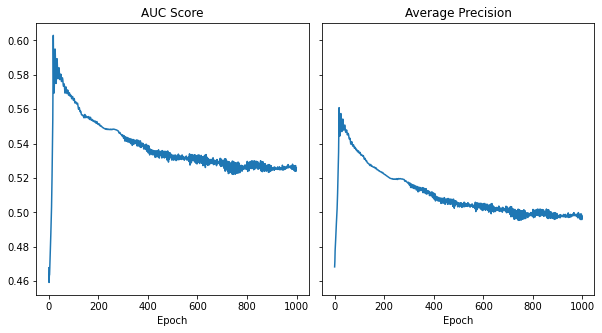

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 5), sharex='all', sharey='all',
                        gridspec_kw={'hspace': 0, 'wspace': 0.05})
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_title('AUC Score')
axs[1].set_title('Average Precision')

axs[0].plot(auc_values, label = "AUC score")
axs[1].plot(ap_values, label = "Average Precision")

plt.show()
